In [14]:
import sys, os
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend/aws') 
sys.path.append('/Users/benjamin/Desktop/repos/chi-data/backend') 
from s3 import S3
from dynamo import DynamoConn
import pyarrow.parquet as pq
import pandas as pd
import geopandas as gpd
import numpy as np
import requests as r
import json
%matplotlib inline
from config import cook_tracts, chicago_tracts, msa_tracts

In [66]:
import s3fs
s3 = s3fs.S3FileSystem()
dataset = 'JT00'
year = '2003'
ds = pq.ParquetDataset(path_or_paths=[
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/il_lehd_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/in_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/in_od_aux_%s_%s.parquet' % (year, dataset, year), 
    
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_main_%s_%s.parquet' % (year, dataset, year), 
  'bnroths/chicago-data/lehd_od/year=%s/wi_od_aux_%s_%s.parquet' % (year, dataset, year), 

], filesystem=s3, validate_schema=False)

In [67]:
table = ds.read(columns=['w_tract', 'h_tract', 'S000'])
df = table.to_pandas()

In [68]:
res = r.get('https://s3.amazonaws.com/chicago.bnroths.com/data/boundaries/ZillowNeighborhaoods-IL.json').json()
with open('zillow.json', 'wb') as f:
	f.write(json.dumps(res))
res = r.get('https://s3.amazonaws.com/chicago.bnroths.com/data/boundaries/Boundaries+-+Census+Tracts+-+2010.json').json()
with open('tracts.json', 'wb') as f:
	f.write(json.dumps(res))

tracts = gpd.read_file('tracts.json')
neighborhoods = gpd.read_file('zillow.json')

tracts_center = tracts
tracts_center['centroid_column'] = tracts.centroid
tracts_center = tracts.set_geometry('centroid_column')
neighborhoods_w_tracts = gpd.sjoin(tracts_center, neighborhoods, how="inner", op='within')
neighborhoods_w_tracts_small = neighborhoods_w_tracts[['geoid10', 'Name']].set_index('geoid10')

In [69]:
stat = 'S000'
table = ds.read(columns=['w_tract', 'h_tract', stat])

In [70]:
df = table.to_pandas()
print df
# exit(0)

final_df = df.set_index('w_tract').join(neighborhoods_w_tracts_small).rename(columns={'Name': 'w_hood'})
final_df = final_df.set_index('h_tract').join(neighborhoods_w_tracts_small, lsuffix='left').rename(columns={'Name': 'h_hood'})


diff1 = set(final_df.h_hood) - set(final_df.w_hood)
for tract in diff1:
    final_df = final_df[final_df.h_hood != tract]

diff2 = set(final_df.w_hood) - set(final_df.h_hood)
for tract in diff2:
    final_df = final_df[final_df.w_hood != tract]

# print final_df.shape
print stat
print final_df.columns
print final_df.head()
pivot = pd.pivot_table(
    final_df, 
    values=stat, 
    columns=['h_hood'], 
    index=['w_hood'], 
    aggfunc=np.sum, 
    fill_value=0)

print pivot

             w_tract      h_tract  S000
0        17001000100  17001010600     1
1        17001000100  17001001001     1
2        17001000100  17001001100     1
3        17001000100  17001001100     1
4        17001000100  17001010500     1
5        17001000100  17021958500     1
6        17001000100  17021958600     1
7        17001000100  17001000100     1
8        17001000100  17001000100     1
9        17001000100  17001000100     1
10       17001000100  17001000100     1
11       17001000100  17001000100     2
12       17001000100  17001000100     1
13       17001000100  17001000100     1
14       17001000100  17001000100     1
15       17001000100  17001000100     1
16       17001000100  17001000100     1
17       17001000100  17001000100     1
18       17001000100  17001000100     1
19       17001000100  17001000100     1
20       17001000100  17001000100     1
21       17001000100  17001000100     1
22       17001000100  17001000100     1
23       17001000100  17001000201     1


In [71]:
w_tracts = pivot.sum()
# row totals (h_tracts)
h_tracts = pivot.transpose().sum()
A = pivot.transpose()/h_tracts
A = A.fillna(0).replace([np.inf, -np.inf], 0)
# print A.shape
w, v = np.linalg.eig(A)

#eigs = []
## eigs may not come back in order so order them real quick
#idx = w.argsort()[::-1]
#eigenValues = w[idx]
#eigenVectors = v[:,idx]
#sub_data = []

In [72]:
A.to_csv("A2003.csv")
#v[:,1]
#v[:, 1]

Axes(0.125,0.125;0.775x0.755)


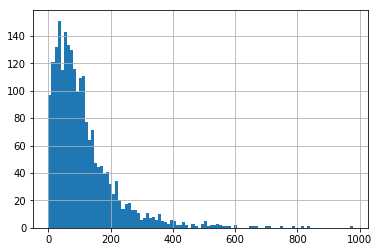

In [85]:
#print pivot[pivot.'17031839100'].head()
print pivot['17031839100'].hist(bins=100)#sort_values(ascending=False)

# df['S000'].sum()#['17001010400']#.head(n=100) #17001010100

In [81]:
pivot.to_csv('/Users/benjamin/Desktop/repos/chi-data/scripts/test.csv')

In [79]:
w_tracts = pivot.sum()
print w_tracts['17031839100']
h_tracts = pivot.transpose().sum()
A = pivot.transpose()/h_tracts
A = A.fillna(0).replace([np.inf, -np.inf], 0)

247951


In [76]:
print A#['17031839100'].sort_values(ascending=False)
#for a in h_tracts:
#    print a

h_tract      17031010100  17031010201  17031010202  17031010300  17031010400  \
w_tract                                                                        
17031010100     0.023069     0.005405     0.004753     0.006017     0.002346   
17031010201     0.002508     0.005019     0.008555     0.001880     0.000939   
17031010202     0.003511     0.008494     0.008555     0.003761     0.000469   
17031010300     0.010030     0.004247     0.001901     0.020308     0.003285   
17031010400     0.005015     0.002703     0.000951     0.010530     0.091976   
17031010501     0.000000     0.000386     0.000000     0.000376     0.000000   
17031010502     0.000000     0.001544     0.003802     0.000000     0.000000   
17031010503     0.000000     0.000386     0.000000     0.000752     0.000000   
17031010600     0.002006     0.008880     0.003802     0.008650     0.002346   
17031010701     0.000000     0.000000     0.000000     0.000000     0.000000   
17031010702     0.000502     0.003089   

In [88]:
w, v = np.linalg.eig(A)

In [89]:
print type(w[0])
print v[0].shape
print w.shape # eigenvalue
print v.shape # eigenvector

<type 'numpy.complex128'>
(2207,)
(2207,)
(2207, 2207)


In [90]:
eigs = []
idx = w.argsort()[::-1]
eigenValues = w[idx]
eigenVectors = v[:,idx]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12216d8d0>]], dtype=object)

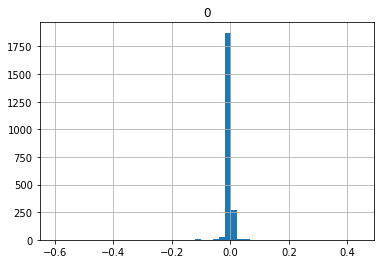

In [134]:
pd.DataFrame(eigenVectors[:,1]).hist(bins=50)

In [ ]:

# print eigenValues
# assert False
# for i in range(eigenValues.shape[0]):
sub_data = []
for i in range(5):
    eigenvalue_i = i+1
    val = round(eigenValues[i], 4)
    vector = eigenVectors[:, i]
    sub_data.append({
        "name": "Eigenvalue %s: %s" % (eigenvalue_i, val),
        "key": str(eigenvalue_i)
    })
    # print i, "value", np.linalg.norm(vector), val
    # print "vector"
    # print vector
    # print type(vector.real)
    transformed = [round(1000*x, 1) for x in vector.real]
    eig = {
        "row": i,
        "value": val,
        "vector": transformed,
        "columns": pivot.columns
    }
    eigs.append(eig)
#     print eigs
    tracts = {}
    for i, column in enumerate(pivot.columns):
        tracts[column] = transformed[i]
        
#     print min(tracts.values())
    


In [ ]:

a = np.array([[0, 1], [-2, -3]])
print a
w, v = np.linalg.eig(a)
print v, w

print w[0], v[:,0]
print w[1], v[:,1]

In [ ]:
from s3 import S3
s3 = S3()